In [3]:
import pandas as pd
import numpy as np
import scipy.io
import umap
import os

from Rcwk.rcwk import Rcwk
from sklearn.cluster import KMeans
from coclust.clustering.spherical_kmeans import SphericalKmeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### <span style="color:Red">Start experiments on 8 algorithms</span>
- K-means: classic k-means algorithm
- Spherical k-means (S-Kmeans)
- Mini-batch k-means
- Spectral clustering
- Non-Negative Matrix Factorization (NMF)
- Deep k-means
- Lasso Weighted k-means (Lwk): original Lwk algorithm with euclidean distance
- Regularized Chi-squared Weighted kmeans (RCW-kmeans): Our proposed algorithm


__Import data__

In [10]:
"""
tfidf 
    * CLASSIC3 | OHSCALE | CSTR | CLASSIC4  | TR45 | SPORTS
    * BBC | NG5 | NG20 
    * HM_ng20 | HM_bbc | HM_pubmed5 | HM_pubmed10 | HM_classic4
"""

data_type = 'tfidf' 
data_name = 'CSTR'

# Load dict file
mat = scipy.io.loadmat(os.path.join('new_data', data_type,data_name))

# Load labels
y = mat['labels'].flatten()
mat = mat['mat'].toarray()
k = len(set(y))

print('Shape :',mat.shape)
print('k :',k)


Shape : (475, 1000)
k : 4


__k-means__

In [29]:
n = 15

res_nmi, res_ari, silh = [],[],[]
for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    mat = mat
    kmeans = KMeans(n_clusters=k, n_init=20).fit(mat)
    res_nmi += [normalized_mutual_info_score(kmeans.labels_,y)]
    res_ari += [adjusted_rand_score(kmeans.labels_,y)]
    silh.append(silhouette_score(mat, kmeans.labels_))

print()
print(f'Best 5\n'
      f'NMI: {np.mean(best_nmi):.2f} ± {np.std(best_nmi):.2f}\n'
      f'ARI: {np.mean(best_ari):.2f} ± {np.std(best_ari):.2f}')
print(f'Mean\n'
      f'NMI: {np.mean(res_nmi):.2f} ± {np.std(res_nmi):.2f}\n'
      f'ARI: {np.mean(res_ari):.2f} ± {np.std(res_ari):.2f}')

Iteration 15 / 15
Best 5
NMI: 0.76 ± 0.02
ARI: 0.81 ± 0.02
Mean
NMI: 0.61 ± 0.03
ARI: 0.50 ± 0.05


__S-kmeans__

In [30]:
n = 15

res_nmi, res_ari, silh = [],[],[]
for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    mat = mat #mat_supp mat_tfidf.toarray()
    sk = SphericalKmeans(n_clusters=k, n_init=20)
    sk.fit(mat)
    res_nmi += [normalized_mutual_info_score(sk.row_labels_,y)]
    res_ari += [adjusted_rand_score(sk.row_labels_,y)]
    silh.append(silhouette_score(mat, sk.row_labels_))

print()
print(f'Best 5\n'
      f'NMI: {np.mean(best_nmi):.2f} ± {np.std(best_nmi):.2f}\n'
      f'ARI: {np.mean(best_ari):.2f} ± {np.std(best_ari):.2f}')
print(f'Mean\n'
      f'NMI: {np.mean(res_nmi):.2f} ± {np.std(res_nmi):.2f}\n'
      f'ARI: {np.mean(res_ari):.2f} ± {np.std(res_ari):.2f}')

Iteration 15 / 15
Best 5
NMI: 0.76 ± 0.02
ARI: 0.81 ± 0.02
Mean
NMI: 0.70 ± 0.04
ARI: 0.71 ± 0.07


__MiniBatchKMeans__

In [21]:
from sklearn.cluster import MiniBatchKMeans

n = 15

res_nmi, res_ari = [],[]
silh, p2 = [],[]
for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    mbkm = MiniBatchKMeans(n_clusters=k).fit_predict(mat)
    res_nmi += [normalized_mutual_info_score(mbkm,y)]
    res_ari += [adjusted_rand_score(mbkm,y)]
    silh.append(silhouette_score(mat, mbkm))


best_nmi = [i[0] for i in sorted(zip(res_nmi, silh), key=lambda x: x[1], reverse=True)][:5]
best_ari = [i[0] for i in sorted(zip(res_ari, silh), key=lambda x: x[1], reverse=True)][:5]

print()
print(f'Best 5\n'
      f'NMI: {np.mean(best_nmi):.2f} ± {np.std(best_nmi):.2f}\n'
      f'ARI: {np.mean(best_ari):.2f} ± {np.std(best_ari):.2f}')
print(f'Mean\n'
      f'NMI: {np.mean(res_nmi):.2f} ± {np.std(res_nmi):.2f}\n'
      f'ARI: {np.mean(res_ari):.2f} ± {np.std(res_ari):.2f}')

Iteration 15 / 15
Best 5
NMI: 0.62 ± 0.04
ARI: 0.57 ± 0.08
Mean
NMI: 0.59 ± 0.07
ARI: 0.51 ± 0.09


__Spectral__

In [22]:
from sklearn.cluster import SpectralClustering

X = mat
n = 15

res_nmi, res_ari = [],[]
silh, p2 = [],[]
for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    sp = SpectralClustering(n_clusters=k, assign_labels='discretize').fit(X)
    res_nmi += [normalized_mutual_info_score(sp.labels_,y)]
    res_ari += [adjusted_rand_score(sp.labels_,y)]
    silh.append(silhouette_score(mat, sp.labels_))

best_nmi = [i[0] for i in sorted(zip(res_nmi, silh), key=lambda x: x[1], reverse=True)][:5]
best_ari = [i[0] for i in sorted(zip(res_ari, silh), key=lambda x: x[1], reverse=True)][:5]

print()
print(f'Best 5\n'
      f'NMI: {np.mean(best_nmi):.2f} ± {np.std(best_nmi):.2f}\n'
      f'ARI: {np.mean(best_ari):.2f} ± {np.std(best_ari):.2f}')
print(f'Mean\n'
      f'NMI: {np.mean(res_nmi):.2f} ± {np.std(res_nmi):.2f}\n'
      f'ARI: {np.mean(res_ari):.2f} ± {np.std(res_ari):.2f}')

Iteration 15 / 15
Best 5
NMI: 0.59 ± 0.00
ARI: 0.47 ± 0.00
Mean
NMI: 0.59 ± 0.01
ARI: 0.47 ± 0.01


__NMF__

In [23]:
from sklearn.decomposition import NMF

n_components = k
n = 15

res_nmi, res_ari = [],[]
silh, p2 = [],[]
for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    nmf = NMF(n_components=k, max_iter=300, init=None)
    W = nmf.fit_transform(mat)
    H = nmf.components_
    nmf_labels = np.argmax(W, axis=1)    
    res_nmi += [normalized_mutual_info_score(nmf_labels,y)]
    res_ari += [adjusted_rand_score(nmf_labels,y)]
    silh.append(silhouette_score(mat, nmf_labels))

best_nmi = [i[0] for i in sorted(zip(res_nmi, silh), key=lambda x: x[1], reverse=True)][:5]
best_ari = [i[0] for i in sorted(zip(res_ari, silh), key=lambda x: x[1], reverse=True)][:5]

print()
print(f'Best 5\n'
      f'NMI: {np.mean(best_nmi):.2f} ± {np.std(best_nmi):.2f}\n'
      f'ARI: {np.mean(best_ari):.2f} ± {np.std(best_ari):.2f}')
print(f'Mean\n'
      f'NMI: {np.mean(res_nmi):.2f} ± {np.std(res_nmi):.2f}\n'
      f'ARI: {np.mean(res_ari):.2f} ± {np.std(res_ari):.2f}')

Iteration 15 / 15
Best 5
NMI: 0.64 ± 0.00
ARI: 0.54 ± 0.00
Mean
NMI: 0.64 ± 0.00
ARI: 0.54 ± 0.00


__LWK__

In [12]:
lamb = 0.00001    
alpha = 0   
beta = 4    
chi2 = 0 #use euclidean distance
scale = 1 #scale for euclidean distance
n = 20
init = 'k' #k-means++ initialisation

res_nmi, res_ari = [],[]
silh, p2 = [],[]

for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    rcwk = Rcwk(k, lambda_val=lamb, alpha=alpha, beta=beta, chi2=chi2, scale=scale, init = init)
    rcwk.fit(mat, verbose=0)
    
    res_nmi += [normalized_mutual_info_score(rcwk.labels_,y)]
    res_ari += [adjusted_rand_score(rcwk.labels_,y)]
    
    silh.append(silhouette_score(mat, rcwk.labels_))
    p2.append(rcwk.P2)

best_nmi = [i[0] for i in sorted(zip(res_nmi, silh), key=lambda x: x[1], reverse=True)][:5]
best_ari = [i[0] for i in sorted(zip(res_ari, silh), key=lambda x: x[1], reverse=True)][:5]

best_nmi_p2 = [i[0] for i in sorted(zip(res_nmi, p2), key=lambda x: x[1], reverse=0)][:5]
best_ari_p2 = [i[0] for i in sorted(zip(res_ari, p2), key=lambda x: x[1], reverse=0)][:5]

print()
print(f'Best 5\n'
      f'NMI: {np.mean(best_nmi):.2f} ± {np.std(best_nmi):.2f}\n'
      f'ARI: {np.mean(best_ari):.2f} ± {np.std(best_ari):.2f}')
print(f'Mean\n'
      f'NMI: {np.mean(res_nmi):.2f} ± {np.std(res_nmi):.2f}\n'
      f'ARI: {np.mean(res_ari):.2f} ± {np.std(res_ari):.2f}')

Iteration 20 / 20
Best 5
NMI: 0.65 ± 0.02
ARI: 0.55 ± 0.02
Mean
NMI: 0.65 ± 0.02
ARI: 0.55 ± 0.02


#### RCW-kmeans

In [13]:
lamb = 0.00001    
alpha = 0   
beta = 4    
scale = 0
chi2 = 1
n = 20
init = 's'

res_nmi, res_ari = [],[]
silh, p2 = [],[]

for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    rcwk = Rcwk(k, lambda_val=lamb, alpha=alpha, beta=beta, chi2=chi2, scale=scale, init = init, )#z=np.array(sk.row_labels_))
    rcwk.fit(mat, verbose=0)
    
    res_nmi += [normalized_mutual_info_score(rcwk.labels_,y)]
    res_ari += [adjusted_rand_score(rcwk.labels_,y)]
    
    silh.append(silhouette_score(mat, rcwk.labels_))
    p2.append(rcwk.P2)

best_nmi = [i[0] for i in sorted(zip(res_nmi, silh), key=lambda x: x[1], reverse=True)][:5]
best_ari = [i[0] for i in sorted(zip(res_ari, silh), key=lambda x: x[1], reverse=True)][:5]

best_nmi_p2 = [i[0] for i in sorted(zip(res_nmi, p2), key=lambda x: x[1], reverse=0)][:5]
best_ari_p2 = [i[0] for i in sorted(zip(res_ari, p2), key=lambda x: x[1], reverse=0)][:5]

print()
print(f'Best 5\n'
      f'NMI: {np.mean(best_nmi):.2f} ± {np.std(best_nmi):.2f}\n'
      f'ARI: {np.mean(best_ari):.2f} ± {np.std(best_ari):.2f}')
print(f'Mean\n'
      f'NMI: {np.mean(res_nmi):.2f} ± {np.std(res_nmi):.2f}\n'
      f'ARI: {np.mean(res_ari):.2f} ± {np.std(res_ari):.2f}')

Iteration 20 / 20
Best 5
NMI: 0.75 ± 0.01
ARI: 0.80 ± 0.01
Mean
NMI: 0.74 ± 0.02
ARI: 0.77 ± 0.04


## <span style="color:Red">Analysis</span>
### <span style="color:blue">I. Clustering vizualisation</span>


In [13]:
# Labels retrieved from Deep k-means run on command line https://github.com/MaziarMF/deep-k-means
lab_DKM = [1, 1, 3, 0, 1, 3, 3, 1, 3, 2, 3, 2, 3, 2, 2, 2, 1, 3, 2, 1, 3, 3, 2, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 2, 3, 1,
          2, 2, 3, 3, 3, 3, 3, 2, 1, 0, 1, 2, 1, 3, 1, 1, 1, 3, 3, 1, 2, 2, 1, 3, 0, 0, 3, 1, 0, 2, 2, 1, 3, 0, 0, 1, 1,
          3, 3, 1, 3, 2, 2, 3, 0, 1, 1, 1, 1, 1, 3, 0, 2, 1, 2, 0, 3, 2, 0, 0, 2, 1, 0, 2, 3, 2, 2, 1, 2, 3, 2, 2, 0, 1,
          3, 3, 3, 3, 3, 3, 2, 1, 2, 2, 1, 2, 3, 2, 1, 2, 0, 1, 2, 2, 0, 3, 3, 3, 3, 1, 2, 0, 1, 3, 3, 1, 2, 2, 2, 0, 3,
          3, 1, 3, 1, 1, 3, 3, 2, 2, 2, 1, 1, 2, 1, 2, 1, 3, 1, 3, 0, 3, 1, 2, 2, 3, 2, 2, 2, 3, 0, 2, 2, 2, 3, 2, 0, 3,
          2, 1, 2, 3, 2, 2, 0, 0, 1, 0, 0, 1, 0, 3, 0, 3, 2, 0, 1, 2, 3, 3, 0, 1, 3, 1, 2, 3, 3, 2, 2, 3, 1, 3, 1, 3, 2,
          3, 1, 0, 2, 1, 2, 0, 0, 0, 3, 3, 0, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 1, 2, 2, 3, 1, 3, 3, 3, 3, 3, 2, 0, 2, 2,
          2, 2, 1, 1, 1, 3, 2, 2, 1, 2, 3, 0, 2, 1, 0, 1, 2, 1, 2, 2, 3, 2, 1, 2, 2, 1, 2, 2, 2, 3, 3, 0, 2, 2, 3, 3, 2,
          2, 1, 2, 3, 2, 1, 3, 1, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3, 1, 1, 0, 3, 3, 0, 1, 1, 2, 3, 1, 2, 2,
          2, 1, 3, 2, 1, 3, 2, 1, 2, 3, 3, 2, 2, 3, 3, 3, 2, 0, 2, 2, 3, 1, 0, 2, 2, 3, 1, 3, 3, 3, 3, 1, 3, 2, 1, 3, 2,
          3, 2, 3, 1, 1, 2, 2, 1, 1, 2, 0, 0, 0, 2, 1, 2, 1, 1, 2, 1, 2, 0, 3, 3, 2, 2, 2, 2, 3, 3, 1, 3, 1, 1, 3, 3, 0,
          3, 0, 1, 3, 2, 1, 3, 2, 2, 0, 3, 2, 3, 1, 2, 3, 2, 0, 3, 2, 1, 2, 0, 3, 1, 3, 2, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3,
          2, 3, 2, 1, 2, 0, 2, 1, 2, 2, 2, 3, 3, 3, 1, 3, 1, 3, 1, 2, 2, 3, 1, 3, 2, 3, 3, 2, 2, 1, 0]

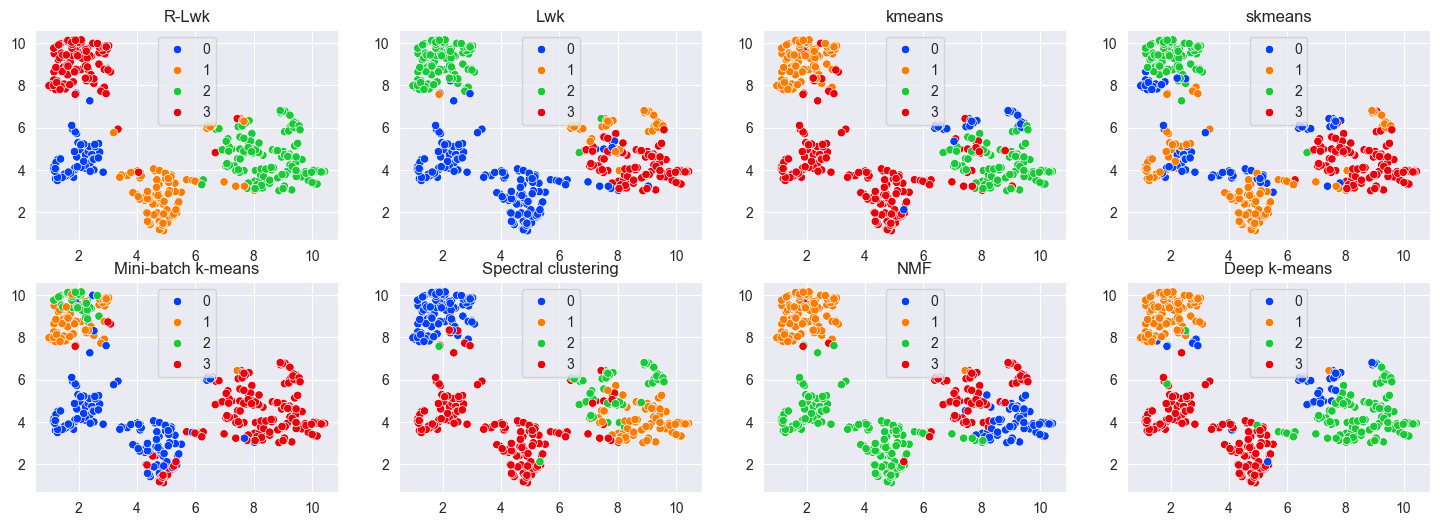

In [ ]:
# Reduce dimension of tf-idf matrix for visualization using Umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(mat)

gs = gridspec.GridSpec(2, 8)
gs.update(wspace=0.5)

plt.figure(figsize=(18, 6))
sns.set_style('darkgrid')

# Rcwk
ax1 = plt.subplot(gs[0, 0:2])
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=rcwk.labels_, palette='bright', ax=ax1)
ax1.set_title('R-Lwk')

# lwk
ax2 = plt.subplot(gs[0, 2:4])
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=lab_lwk, palette='bright', ax=ax2)
ax2.set_title('Lwk')

# kmeans
ax3 = plt.subplot(gs[0, 4:6])
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=kmeans.labels_, palette='bright', ax=ax3)
ax3.set_title('kmeans')

# skmeans
ax4 = plt.subplot(gs[0, 6:8])
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=sk.labels_, palette='bright', ax=ax4)
ax4.set_title('skmeans')

# Mini batch
ax5 = plt.subplot(gs[1, 0:2])
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=mbkm, palette='bright', ax=ax5)
ax5.set_title('Mini-batch k-means')

# Spectral
ax6 = plt.subplot(gs[1, 2:4])
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=sp.labels_, palette='bright', ax=ax6)
ax6.set_title('Spectral clustering')

# NMF
ax7 = plt.subplot(gs[1, 4:6])
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=nmf_labels, palette='bright', ax=ax7)
ax7.set_title('NMF')

# Deep k-means
ax7 = plt.subplot(gs[1, 6:8])
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=lab_DKM, palette='bright', ax=ax7)
ax7.set_title('Deep k-means')
plt.show()


### <span style="color:blue">II. Silhouette coherence</span>
Run 20 times on each dataset and store NMI and Silhouette scores 

In [10]:
"""
tfidf 
    * CLASSIC3 | OHSCALE | CSTR | CLASSIC4  | TR45 | SPORTS
    * BBC | NG5 | NG20 
    * HM_ng20 | HM_bbc | HM_pubmed5 | HM_pubmed10 | HM_classic4
"""

data_type = 'tfidf' 
data_name = 'CSTR'

# Load dict file
mat = scipy.io.loadmat(os.path.join('new_data', data_type,data_name))

# Load labels
y = mat['labels'].flatten()
mat = mat['mat'].toarray()
k = len(set(y))

print('Shape :',mat.shape)
print('k :',k)

Shape : (475, 1000)
k : 4


In [6]:
lamb = 0.00001    
alpha = 0   
beta = 4    
scale = 0
chi2 = 1
n = 20
init = 's'

res_nmi, res_ari = [],[]
silh, p2 = [],[]

for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    rcwk = Rcwk(k, lambda_val=lamb, alpha=alpha, beta=beta, chi2=chi2, scale=scale, init = init, )#z=np.array(sk.row_labels_))
    rcwk.fit(mat, verbose=0)
    
    res_nmi += [normalized_mutual_info_score(rcwk.labels_,y)]
    res_ari += [adjusted_rand_score(rcwk.labels_,y)]
    
    silh.append(silhouette_score(mat, rcwk.labels_))
    p2.append(rcwk.P2)

#res_nmi_sports = res_nmi; silh_sports=silh
#res_nmi_tr45 = res_nmi; silh_tr45=silh
#res_nmi_classic4 = res_nmi; silh_classic4=silh
#res_nmi_ohscale = res_nmi; silh_ohscale=silh
#res_nmi_ng20 = res_nmi; silh_ng20=silh
#res_nmi_bbc = res_nmi; silh_bbc=silh
#res_nmi_cstr = res_nmi; silh_cstr=silh
#res_nmi_classic3 = res_nmi; silh_classic3=silh

Iteration 20 / 20

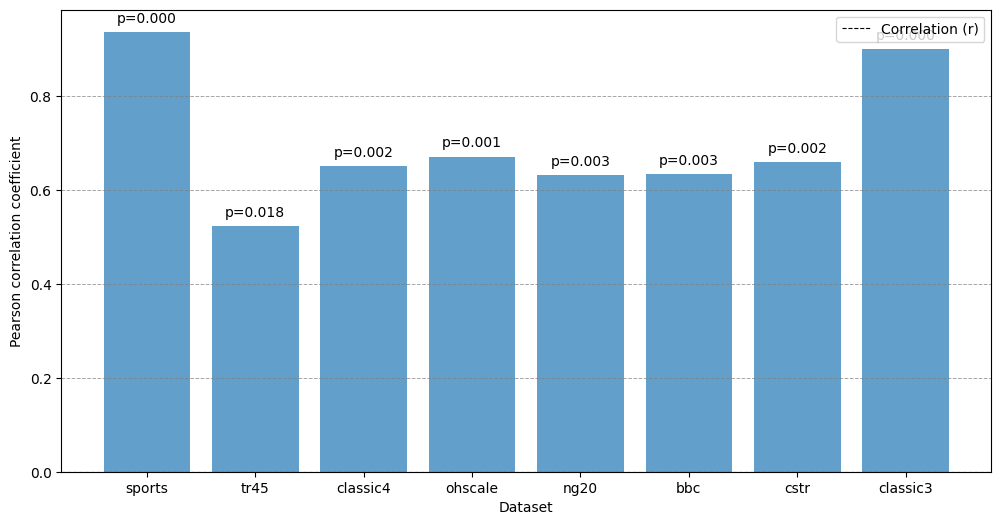

In [232]:
results = {"Dataset": [], "Correlation (r)": [], "p-value": []}

data = {
    "sports": {"res_nmi": res_nmi_sports, "silh": silh_sports},
    "tr45": {"res_nmi": res_nmi_tr45, "silh": silh_tr45},
    "classic4": {"res_nmi": res_nmi_classic4, "silh": silh_classic4},
    "ohscale": {"res_nmi": res_nmi_ohscale, "silh": silh_ohscale},
    "ng20": {"res_nmi": res_nmi_ng20, "silh": silh_ng20},
    "bbc": {"res_nmi": res_nmi_bbc, "silh": silh_bbc},
    "cstr": {"res_nmi": res_nmi_cstr, "silh": silh_cstr},
    "classic3": {"res_nmi": res_nmi_classic3, "silh": silh_classic3}
}

for dataset, values in data.items():
    r, p = pearsonr(values["res_nmi"], values["silh"])
    results["Dataset"].append(dataset)
    results["Correlation (r)"].append(r)
    results["p-value"].append(p)

results_df = pd.DataFrame(results)

plt.style.use('default') 
plt.figure(figsize=(12, 6), facecolor='white')  

# Plot correlations
plt.bar(results_df["Dataset"], results_df["Correlation (r)"], alpha=0.7)

# Add p-values
for i, p_value in enumerate(results_df["p-value"]):
    plt.text(i, results_df["Correlation (r)"][i] + 0.02, f"p={p_value:.3f}", ha='center')

# Add horizontal lines
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7, color='grey') 
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

plt.ylabel("Pearson correlation coefficient")
plt.xlabel("Dataset")
plt.legend(["Correlation (r)"])
plt.show()

### <span style="color:blue">III. Parameter tuning</span>
#### 1. Lambda

In [7]:
alpha = 0
beta = 3
scale = 0
chi2 = 1
n = 20
init = 's'

results_nmi = {}
results_ari = {}
results_silh = {}

#lambdas = np.arange(0., 0.1,0.01)[1:]
lambdas = [5e-1, 4e-1, 3e-1, 2e-1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-10, 0, 1]
for lamb in lambdas:
    res_nmi, res_ari, silh = [], [], []
    for i in range(n):
        print(f'Lambda: {lamb} - Iteration {i+1}/{n}    ', end="\r")
        rcwk = Rcwk(k, lambda_val=lamb, alpha=alpha, beta=beta, chi2=chi2, scale=scale, init = init)
        rcwk.fit(mat, verbose=0)
        
        res_nmi.append(normalized_mutual_info_score(rcwk.labels_, y))
        res_ari.append(adjusted_rand_score(rcwk.labels_, y))
        silh.append(silhouette_score(mat, rcwk.labels_))
    
    results_nmi[lamb] = res_nmi
    results_ari[lamb] = res_ari
    results_silh[lamb] = silh

#results_nmi_classic3 = results_nmi
#results_nmi_classic4 = results_nmi
#results_nmi_bbc = results_nmi
#results_nmi_cstr = results_nmi
#results_nmi_tr45 = results_nmi
#results_nmi_sports = results_nmi
#results_nmi_ohscale = results_nmi

Lambda: 1 - Iteration 20/20         

Text(0, 0.5, 'NMI score')

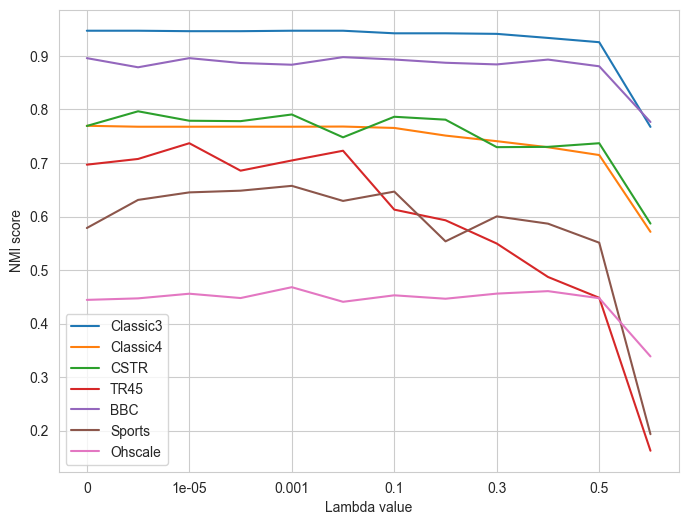

In [147]:
def sort_dict_by_key(d):
    return dict(sorted(d.items()))

sorted_results_nmi_classic3 = sort_dict_by_key(results_nmi_classic3)
sorted_results_nmi_classic4 = sort_dict_by_key(results_nmi_classic4)
sorted_results_nmi_bbc = sort_dict_by_key(results_nmi_bbc)
sorted_results_nmi_cstr = sort_dict_by_key(results_nmi_cstr)
sorted_results_nmi_tr45 = sort_dict_by_key(results_nmi_tr45)
sorted_results_nmi_sports = sort_dict_by_key(results_nmi_sports)
sorted_results_nmi_ohscale = sort_dict_by_key(results_nmi_ohscale)

nmi_results_pd = pd.DataFrame({
    'Lambda value' : [str(i) for i in sorted_results_nmi_classic3.keys()],
    'Classic3' : [np.max(sorted_results_nmi_classic3[i]) for i in sorted_results_nmi_classic3],
    'Classic4' : [np.max(sorted_results_nmi_classic4[i]) for i in sorted_results_nmi_classic4],
    'CSTR' : [np.max(sorted_results_nmi_cstr[i]) for i in sorted_results_nmi_cstr],
    'TR45' : [np.max(sorted_results_nmi_tr45[i]) for i in sorted_results_nmi_tr45],
    'BBC' : [np.max(sorted_results_nmi_bbc[i]) for i in sorted_results_nmi_bbc],
    'Sports' : [np.max(sorted_results_nmi_sports[i]) for i in sorted_results_nmi_sports],
    'Ohscale' : [np.max(sorted_results_nmi_ohscale[i]) for i in sorted_results_nmi_ohscale]
})
nmi_results_pd.set_index('Lambda value').plot(figsize=(8,6))
plt.ylabel('NMI score')

### 2. Initialisation

In [12]:
alpha = 0
beta = 3
scale = 0
chi2 = 1
lamb = 0.0001
n = 20

results_nmi = {}
results_ari = {}
results_silh = {}

inits = ['r', 's', 'k']
for init in inits:
    res_nmi, res_ari, silh = [], [], []
    for i in range(n):
        print(f'Init: {init} - Iteration {i+1}/{n}   ', end="\r")
        print()
        rcwk = Rcwk(k, lambda_val=lamb, alpha=alpha, beta=beta, chi2=chi2, scale=scale, init=init)
        rcwk.fit(mat, verbose=0)
        
        res_nmi.append(normalized_mutual_info_score(rcwk.labels_, y))
        res_ari.append(adjusted_rand_score(rcwk.labels_, y))
        silh.append(silhouette_score(mat, rcwk.labels_))
    
    results_nmi[init] = res_nmi
    results_ari[init] = res_ari
    results_silh[init] = silh

Init: k - Iteration 20/20   

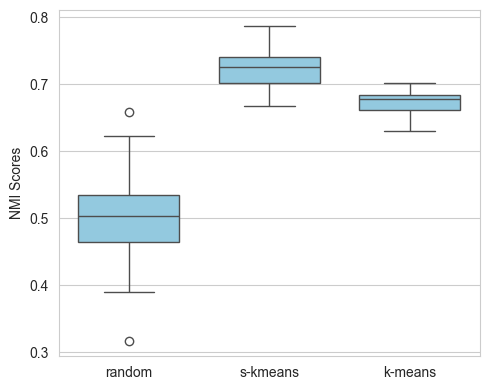

In [24]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(5, 4))

sns.boxplot(
    data=[results_nmi[init] for init in inits],
    ax=ax,
    gap=0.1,
    color="skyblue",
    native_scale=False,
    linecolor='0.3'
)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['random', 's-kmeans', 'k-means'])
ax.set_ylabel('NMI Scores')

plt.tight_layout()
plt.show()

### <span style="color:blue">IV. Weights analysis</span>

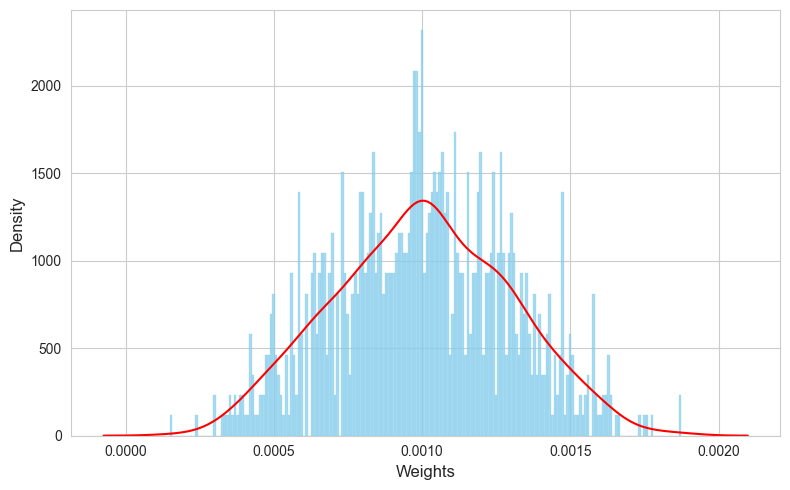

In [236]:
weights = spek.weights_
plt.figure(figsize=(8, 5))

# Histogram
sns.histplot(weights, bins=200, kde=False, stat='density', color='skyblue', edgecolor='skyblue')
sns.kdeplot(weights, color='red')
#plt.title('Weights distribution histogram', fontsize=15)
plt.xlabel('Weights', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

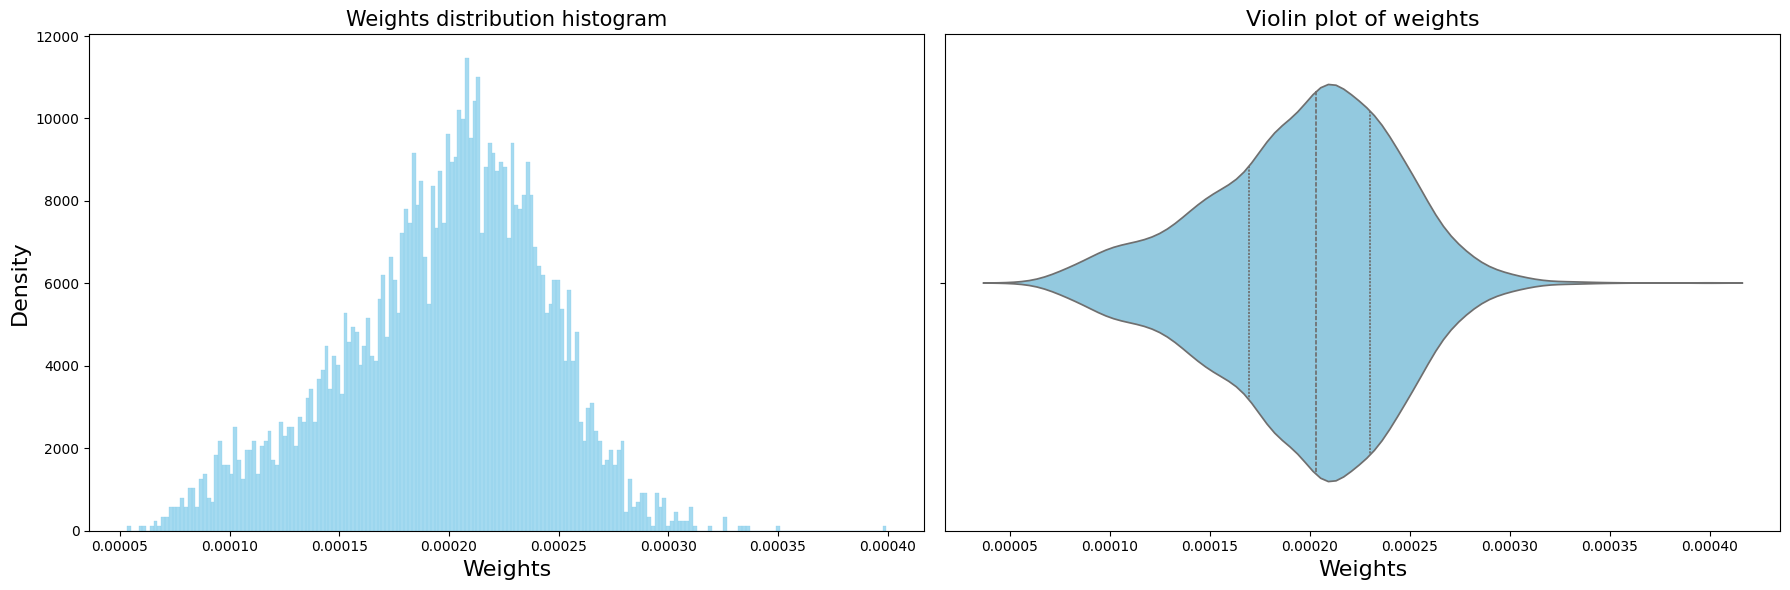

In [135]:
weights = spek.weights_
plt.figure(figsize=(18, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(weights, bins=200, kde=False, stat='density', color='skyblue', edgecolor='skyblue')
#sns.kdeplot(weights, color='red')
plt.title('Weights distribution histogram', fontsize=15)
plt.xlabel('Weights', fontsize=16)
plt.ylabel('Density', fontsize=16)

# Violin plot
plt.subplot(1, 2, 2)
sns.violinplot(x=weights, inner="quartile", color='skyblue')
plt.title('Violin plot of weights', fontsize=16)
plt.xlabel('Weights', fontsize=16)

plt.tight_layout()
plt.show()